In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from layers.QConv2D import QConv2D
from circuits.random import ry_random
from utils.plotter import *
from data.datahandler import datahandler
from data.datareader import datareader

import pennylane as qml
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

# Load dataset

In [3]:
dhandler = datahandler(os.path.join('datasets', 'EuroSAT'))
dhandler.print_report(name = 'EuroSAT')

Dataset EuroSAT

Class 0 - Forest               - #images: 3000
Class 1 - River                - #images: 2500
Class 2 - Highway              - #images: 2500
Class 3 - AnnualCrop           - #images: 3000
Class 4 - SeaLake              - #images: 3000
Class 5 - HerbaceousVegetation - #images: 3000
Class 6 - Industrial           - #images: 2500
Class 7 - Residential          - #images: 3000
Class 8 - PermanentCrop        - #images: 2500
Class 9 - Pasture              - #images: 2000


In [4]:
subA, subB = dhandler.split(None, 0.2)
dhandler.print_report(subA, name='Training Split')
dhandler.print_report(subB, name='Validation Split')

Dataset Training Split

Class 0 - Forest               - #images: 2400
Class 1 - River                - #images: 2000
Class 2 - Highway              - #images: 2000
Class 3 - AnnualCrop           - #images: 2400
Class 4 - SeaLake              - #images: 2400
Class 5 - HerbaceousVegetation - #images: 2400
Class 6 - Industrial           - #images: 2000
Class 7 - Residential          - #images: 2400
Class 8 - PermanentCrop        - #images: 2000
Class 9 - Pasture              - #images: 1600
Dataset Validation Split

Class 0 - Forest               - #images: 600
Class 1 - River                - #images: 500
Class 2 - Highway              - #images: 500
Class 3 - AnnualCrop           - #images: 600
Class 4 - SeaLake              - #images: 600
Class 5 - HerbaceousVegetation - #images: 600
Class 6 - Industrial           - #images: 500
Class 7 - Residential          - #images: 600
Class 8 - PermanentCrop        - #images: 500
Class 9 - Pasture              - #images: 400


In [5]:
labels_mapper, x_train, y_train = dhandler.unpack(subA)
labels_mapper, x_val,   y_val   = dhandler.unpack(subB)

print('Dataset Size')
print('Training   --- {}'.format(len(x_train)))
print('Validation --- {}'.format(len(x_val)))

print('\nTraining Dataset samples')
print('X Train --- {} '.format(x_train[0]))
print('Y Train --- {} '.format(y_train[0]))

Dataset Size
Training   --- 21600
Validation --- 5400

Training Dataset samples
X Train --- datasets/EuroSAT/Forest/Forest_864.jpg 
Y Train --- [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 


In [12]:
data, metadata = datareader.load(x_train[0])

In [ ]:
for i, (x, y) in enumerate(datareader.generator((x_train, y_train), 16, (64,64,3))):
    if i > 2*len(x_train):
        break
    if i%1000==1:
        print('\r{}/{}'.format(i,len(x_train)), end='\t')

2001/21600	

In [8]:
print(i, x, y)

NameError: name 'i' is not defined

In [55]:
QUBITS      = 16
KERNEL_SIZE = 3
FILTERS     = 6
N_LAYERS    = 1
STRIDE      = 2
NUM_JOBS    = 10

In [64]:
circuit = ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS)

In [131]:
drawer = qml.draw(circuit)
print(drawer(np.random.rand(QUBITS)))

 0: ──RY(2.52)─╭RandomLayers(M0)─┤  <Z>
 1: ──RY(3.02)─├RandomLayers(M0)─┤  <Z>
 2: ──RY(1.92)─├RandomLayers(M0)─┤  <Z>
 3: ──RY(0.64)─├RandomLayers(M0)─┤  <Z>
 4: ──RY(0.89)─├RandomLayers(M0)─┤  <Z>
 5: ──RY(1.12)─├RandomLayers(M0)─┤  <Z>
 6: ──RY(0.91)─├RandomLayers(M0)─┤     
 7: ──RY(1.65)─├RandomLayers(M0)─┤     
 8: ──RY(1.85)─├RandomLayers(M0)─┤     
 9: ───────────├RandomLayers(M0)─┤     
10: ───────────├RandomLayers(M0)─┤     
11: ───────────├RandomLayers(M0)─┤     
12: ───────────├RandomLayers(M0)─┤     
13: ───────────├RandomLayers(M0)─┤     
14: ───────────├RandomLayers(M0)─┤     
15: ───────────╰RandomLayers(M0)─┤     


In [66]:
conv1 = QConv2D(
    ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS),
    FILTERS, 
    KERNEL_SIZE, 
    STRIDE, 
    NUM_JOBS
)
conv2 = QConv2D(
    ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS),
    FILTERS, 
    KERNEL_SIZE, 
    STRIDE, 
    NUM_JOBS
)
conv3 = QConv2D(
    ry_random(QUBITS, KERNEL_SIZE, FILTERS, N_LAYERS),
    FILTERS, 
    KERNEL_SIZE, 
    STRIDE, 
    NUM_JOBS
)

In [84]:
#img = np.zeros((64,64,3))
#img[16:48, 16:48, :] = np.ones((48-16, 48-16, 3))

img = np.random.rand(96,96,3)
out1 = conv1.apply(img, verbose = True)
out2 = conv2.apply(out1, verbose = True)
out3 = conv2.apply(out2, verbose = True)

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [86]:
print('Image shape       ', img.shape)
print('QuaConv2D L1 shape', out1.shape)
print('QuaConv2D L2 shape', out2.shape)
print('QuaConv2D L3 shape', out3.shape)

Image shape        (96, 96, 3)
QuaConv2D L1 shape (47, 47, 6)
QuaConv2D L2 shape (22, 22, 6)
QuaConv2D L3 shape (10, 10, 6)


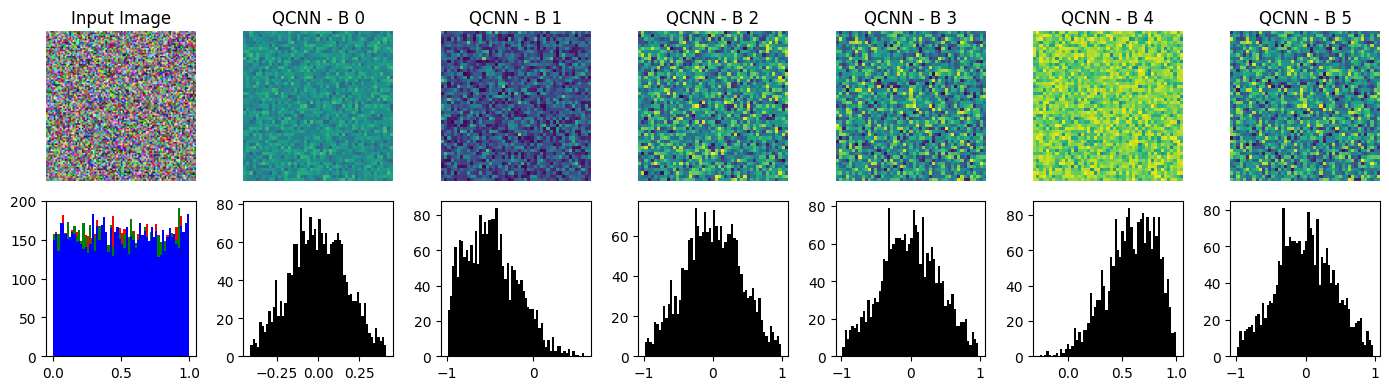

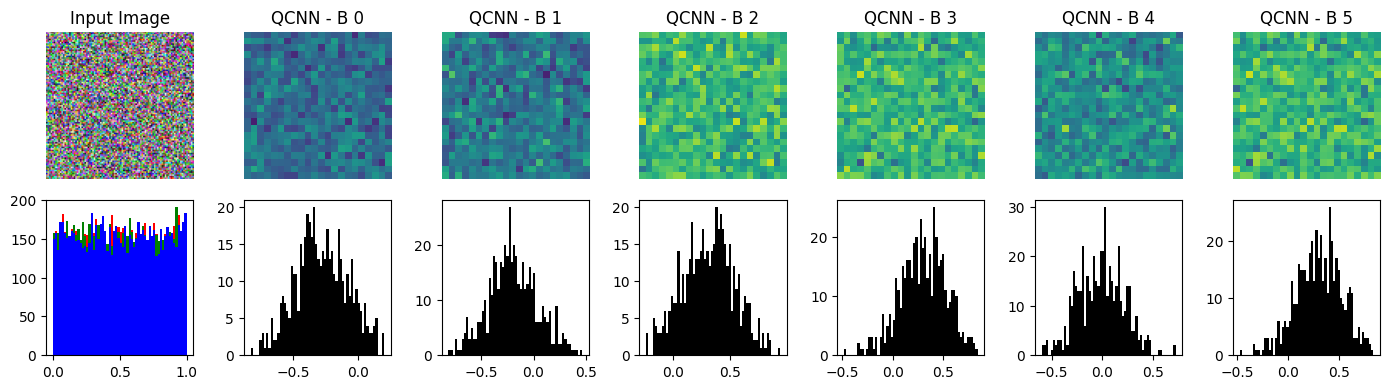

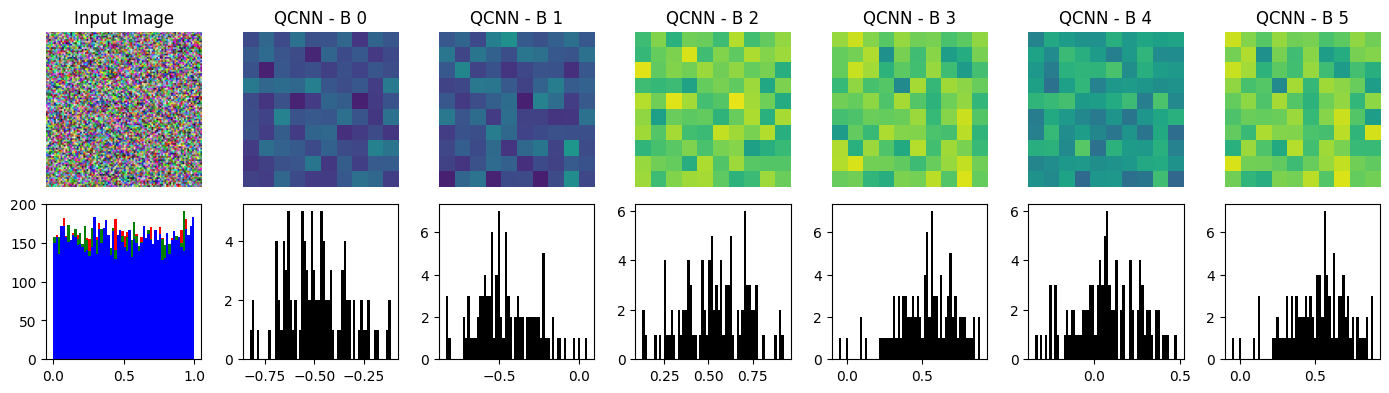

In [85]:
plot_result(img, out1)
plot_result(img, out2)
plot_result(img, out3)